# Broker Selection- Why Not Always Go To The "Best" ?

For the OTC instruments that are traded over voice, a trader chooses one or two broker from the all available ones to trade with. Someone asked the other day why if we should simply go to the top ranked brokers for every clip. Here I demonstrate why going to our top one or two brokers every time is not the best idea.

Let’s start with stating the objective of this exercise- to minimize the total cost of all trades in a day for a given ticker. The demonstration relates to the problem of [N-armed bandit] (https://en.wikipedia.org/wiki/Multi-armed_bandit), translated to our language and situation below: 

*For a given ticker, we have a few clips to execute over the course of the day. For each clip, we have N different brokers to choose from. On choosing any broker, we pay some cost which we assume comes from a stationary pdf. Our objective is to minimize the cost over the day. Now suppose we believe (estimate) that GS has the lowest expected cost and the costs for other brokers are uncertain but close to this value. Which broker should we choose for various clips?*

### Exploration vs Exploitation

This is the exploration vs exploitation dilemma. We can exploit our knowledge and choose the broker that we believe (estimate) has the lowest expected cost- call this the “greedy action”. An exploration strategy could be that we choose the greedy action most of the time, but choose a random action in ε fraction of cases. This is called a “ε-greedy” strategy.

A numerical simulation can shed some light. Let's also explicitly state some major assumptions here:

1. Succesive clips are not autocorrelated so you are free to go to the same broker repeatedly without the fear of them skewing away from you.
2. Cost for each broker is stationary.
3. We have a good way of measuring the realized cost (assumed to be bid-offer plus market impact) of each clip.
4. Cost is the only criterion in choosing brokers, implying that the rest of the quality of service is immaterial.

## The setup and the variables
Assume we have 1000 trades to do, and for each trade we have 10 choices of brokers. The true expected cost of trading with any broker is unknown to us. Lets fix the unknown true expected cost at some random values derived from a std normal distribution.

At each step (1000 trades) of a given simulation (2000 simulations), we choose a broker and pay/realize a cost = mean cost for the chosen broker + noise. The noise is a standard normal random variable. I have also declared a noise multiplier which can be changed to see the effect of noise on the performance of a given broker selection strategy as discussed later.

I have used vectorization but kept the dimentions of various arrays/dataframes to 2. I hope it makes it easier to keep track of the logic without hampering readability

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # to recreate the same raw data every time
brokers_n = 10 # number of brokers in the pool
trades_n = 1000 # number of trades to do
simulations_n = 2000 # number of simulations to run and average over
true_cost_a = np.random.randn(brokers_n, simulations_n) # true value of expected cost 
noise_a = np.random.randn(trades_n, simulations_n)

## Simulation function

The function below works in accordance with the setup described above. We start with some initial assumption of cost of various brokers, which is same for each broker but can be changed with the variable 'init_est_mult'.

Every strategy (every value of ε) maintains an estimate of the expected cost for every broker, which is simply given by the brokers’ in-sample average cost at that point in time. I take average values across simulations of each step (trade) to show how a given strategy can be expected to perform over time.

In [49]:
def run_simulations(epsilons, brokers, simulations, trades, noise_mult=1, init_est_mult=1, y_lim =''):

    simulations_a = np.arange(simulations)
    noise = noise_mult* noise_a
    
    for ei, eps in enumerate (epsilons):
        bkr_cumcost = np.zeros((brokers, simulations)) # cum realized cost at a time for each broker in each simulation
        bkr_count   = np.zeros((brokers, simulations)) # no of times a broker has been selected upto a given point in each sim
        bkr_est     = init_est_mult * np.ones ((brokers, simulations)) # estimated value of expected cost
        rlzd        = pd.DataFrame(np.zeros((trades, simulations)))

        for t in np.arange(trades):
            if t == 0: # choose any random broker at first step
                brokers_now = np.random.randint(0, brokers, simulations)
            else:
                brokers_now = bkr_est.argmin(0) # greedy action 
                throws = np.random.uniform (0, 1, simulations) # dice throw to select eps proportion of brokers randomly
                brokers_now[throws < eps] = np.random.randint (0, brokers, (throws < eps).sum())
                
            rlzd.iloc[t,:] = true_cost_a[brokers_now, simulations_a] + noise[t,:] # actual cost realized = true expected + noise
            
            '''update broker cost estimates for the next step/trade'''
            bkr_cumcost[brokers_now, simulations_a] = bkr_cumcost[brokers_now, simulations_a] + rlzd.iloc[t,:]
            bkr_count  [brokers_now, simulations_a] = bkr_count  [brokers_now, simulations_a] + 1
            bkr_est    [brokers_now, simulations_a] = bkr_cumcost[brokers_now, simulations_a] / bkr_count  [brokers_now, simulations_a] 
            
        plt.plot( rlzd.mean(axis = 1), label = eps)
        plt.legend( loc = 'best' )
        plt.xlabel('Trade Number ->')
        plt.ylabel('Average cost over '+ str(simulations) + ' simulations')
        if y_lim != "":
            plt.ylim(ymax = y_lim)
    plt.show()

Now lets run the simulation, with variables decalred before and a selected list of epsilons. Note that ε=0 corresponds to pure greedy strategy.

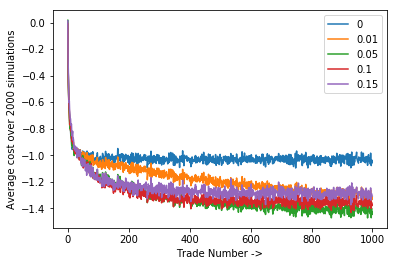

In [50]:
%matplotlib inline
epsilons_a = [0 , 0.01, 0.05, 0.1, 0.15]
noise_mult_n = 1 # noise multiplier to increase or decrease variation of realized reward 
init_est_mult_n = 0 # multiplier to change the initial cost estimates, changing it changes the exploration pattern
run_simulations(epsilons_a, brokers_n, simulations_n, trades_n, noise_mult_n, init_est_mult_n)


The simulation shows how a given strategy (ε) learns about the relative costs and improves its action selection over time. Clearly the greedy strategy seems suboptimal in this case as choosing a
relatively small value of ε=0.01 increases the learning dramatically. There is a limit to the value added by exploration though with ε=0.05 being close to the best in this case. Both lower and higher
values of ε lead to a lower expected reward per step.

In the case above, the initial estimates of expected reward were set at zero for each action. Setting the initial estimates at a lower value of -1 changes the result of the simulation.

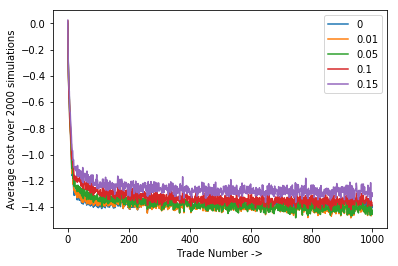

In [51]:
init_est_mult_n = -1
run_simulations(epsilons_a, brokers_n, simulations_n, trades_n, noise_mult_n, init_est_mult_n)

For clarity, I zoom in and remove ε= 0.01 and 0.15.

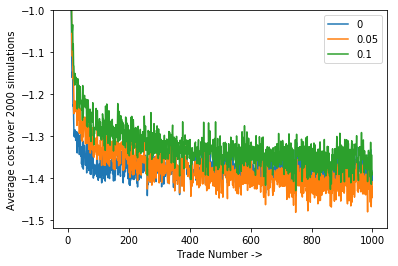

In [52]:
epsilons_a = [0 , 0.05, 0.1]
run_simulations(epsilons_a, brokers_n, simulations_n, trades_n, noise_mult_n, init_est_mult_n, -1)

Greedy strategy doesn’t seem that bad now. It performs better than ε=0.1 although ε=0.05 still performs the best. What is happening is that a low initial cost estimate forces the greedy strategy to explore more than it otherwise would. This leads to it behave similar to a ε-greedy strategy temporarily as it is unable to find a broker with cost lower than the initial estimate. This temporary exploration enables it to estimate the best brokers better.

This leads to the next question- what about the variance of rewards (noise). Intuitively,the effect of noise can be understood by assuming noise = 0. In this case, assuming initial estimates are set relatively low, a greedy action would quickly figure out the best broker due to temporary exploration and stick with that broker later on. ε-greedy strategies would be suboptimal in zero variance case.

To see the effect of higher variance, I increase the variance of rewards to 5 from 1 in the previous simulation. Now again the greedy strategy underperforms as seen below. This is because, due to higher variance in rewards, it now takes more exploration to find out the best actions. We have seen that the market impact across brokers tends to be extremely noisy so we should be leaning towards more exploration.

In the code below, try changing the noise multiplier to zero and initial estimate multiplier to -2 below to the effect of lower noise as discussed above.

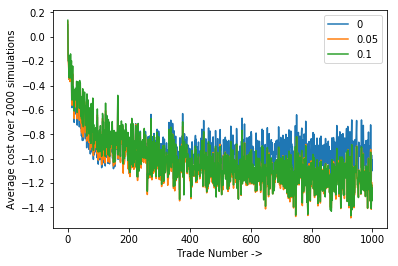

In [53]:
noise_mult_n = 5
run_simulations(epsilons_a, brokers_n, simulations_n, trades_n, noise_mult_n, init_est_mult_n)

Furthermore, if the costs are non-stationary, as they most likely are in case of brokers, continuous exploration would be needed to keep up with the changing means.